In [8]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
import metric as me

def normalize_image(image, min_val=None, max_val=None):
    if min_val is None:
        min_val = np.min(image)
    if max_val is None:
        max_val = np.max(image)
    return (image - min_val) / (max_val - min_val), min_val, max_val

def combine_patches_blured(parent_folder, key, focus_patch_n):
    patches = []
    focus_patch = None
    for folder_name in os.listdir(parent_folder):
        image_folder = os.path.join(parent_folder, folder_name)
        for file in os.listdir(image_folder):
            file_path = os.path.join(image_folder, file)
            if file_path.endswith('.mat'):
                patch = sio.loadmat(file_path)[key]
                patch_rgb = patch[:, :, ]
                patches.append(patch_rgb)
                if folder_name.endswith(str(focus_patch_n).zfill(2)):
                    focus_patch = patch_rgb

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image, min_val, max_val = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    if focus_patch is not None:
        focus_patch = normalize_image(focus_patch, min_val, max_val)[0]

    return image, focus_patch

def combine_patches(image_paths, patch_key_prefix, patch_n):
    patches = []
    focus_patch = None

    data = sio.loadmat(image_paths)
    for i in range(1, 34):  # Assuming there are 33 patches
        patch_key = f"{patch_key_prefix}_{str(i).zfill(2)}_pred"
        if patch_key in data:
            patch = data[patch_key]
            patch_rgb = patch[:, :, ]  # Assuming these are the R, G, B channels
            patches.append(patch_rgb)
            if i == patch_n:
                focus_patch = patch_rgb

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image, min_val, max_val = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    if focus_patch is not None:
        focus_patch = normalize_image(focus_patch, min_val, max_val)[0]

    return image, focus_patch

def show(image, ax, title=None, focus_patch_n=None, patch_size=None, with_border=False):
    ax.axis('off')
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if focus_patch_n and patch_size:  # If the number and size of the focus_patch are provided
        grid_width = 3
        grid_height = 11
        patch_width, patch_height = patch_size
        focus_patch_n -= 1  # Adjust the focus patch number to be zero-indexed
        x = (focus_patch_n % grid_width) * patch_width
        y = (focus_patch_n // grid_width) * patch_height
        # Ensure the rectangle is within the bounds of the image
        x = min(x, image.shape[1] - patch_width)
        y = min(y, image.shape[0] - patch_height)
        rect = Rectangle((x, y), patch_width, patch_height, edgecolor='r', facecolor='none')  # Create a red square
        ax.add_patch(rect)  # Add the square to the image
    if with_border:
        rect = Rectangle((0, 0), image.shape[1]-1.5, image.shape[0]-1.5, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

image_paths = '/home/kimado/master/DIP-HyperKite/Experiments/DHP_DARN/hico_dataset/N_modules_2/final_prediction.mat'
paths = '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010026150016.L1B_ISS.nc'
num = 5

image, patch = combine_patches(image_paths, 'H2010026150016.L1B_ISS.nc', num)
ref, ref_patch = combine_patches_blured(paths, 'ref', num)
blurred, blurred_patch = combine_patches_blured(paths, 'blurred', num)

qnr, lam, dsr = me.qnr(blurred, image, 43)
print("qnr: ", qnr, "lam: ", lam, "dsr: ", dsr)

focus_patch_n = 5  # Replace with the actual number of the focus_patch
patch_size = (170, 170)  # Replace with the actual size of the patches
fig = plt.figure(figsize=(7, 21))

# Display the main images
ax1 = fig.add_axes([0.0, 0.5, 0.33, 0.5])  # left, bottom, width, height
show(ref, ax1, None, focus_patch_n, patch_size)

ax2 = fig.add_axes([0.35, 0.5, 0.33, 0.5])
show(blurred, ax2, None, focus_patch_n, patch_size)

ax3 = fig.add_axes([0.7, 0.5, 0.33, 0.5])
show(image, ax3, None, focus_patch_n, patch_size)

# Display the patches
ax4 = fig.add_axes([0.0, 0.24, 0.33, 0.5])
show(ref_patch, ax4, with_border=True)

ax5 = fig.add_axes([0.35, 0.24, 0.33, 0.5])
show(blurred_patch, ax5, with_border=True)

ax6 = fig.add_axes([0.7, 0.24, 0.33, 0.5])
show(patch, ax6, with_border=True)

# Add labels to the bottom of each patch
ax4.text(0.5, -0.05, '(a)', transform=ax4.transAxes, horizontalalignment='center', verticalalignment='center')
ax5.text(0.5, -0.05, '(b)', transform=ax5.transAxes, horizontalalignment='center', verticalalignment='center')
ax6.text(0.5, -0.05, '(c)', transform=ax6.transAxes, horizontalalignment='center', verticalalignment='center')
plt.savefig('/home/kimado/master/HYPSO-1/fig/016-darn.pdf', format='pdf', bbox_inches='tight')

plt.show()


"\nfocus_patch_n = 5  # Replace with the actual number of the focus_patch\npatch_size = (170, 170)  # Replace with the actual size of the patches\nfig = plt.figure(figsize=(7, 21))\n\n# Display the main images\nax1 = fig.add_axes([0.0, 0.5, 0.33, 0.5])  # left, bottom, width, height\nshow(ref, ax1, None, focus_patch_n, patch_size)\n\nax2 = fig.add_axes([0.35, 0.5, 0.33, 0.5])\nshow(blurred, ax2, None, focus_patch_n, patch_size)\n\nax3 = fig.add_axes([0.7, 0.5, 0.33, 0.5])\nshow(image, ax3, None, focus_patch_n, patch_size)\n\n# Display the patches\nax4 = fig.add_axes([0.0, 0.24, 0.33, 0.5])\nshow(ref_patch, ax4, with_border=True)\n\nax5 = fig.add_axes([0.35, 0.24, 0.33, 0.5])\nshow(blurred_patch, ax5, with_border=True)\n\nax6 = fig.add_axes([0.7, 0.24, 0.33, 0.5])\nshow(patch, ax6, with_border=True)\n\n# Add labels to the bottom of each patch\nax4.text(0.5, -0.05, '(a)', transform=ax4.transAxes, horizontalalignment='center', verticalalignment='center')\nax5.text(0.5, -0.05, '(b)', trans

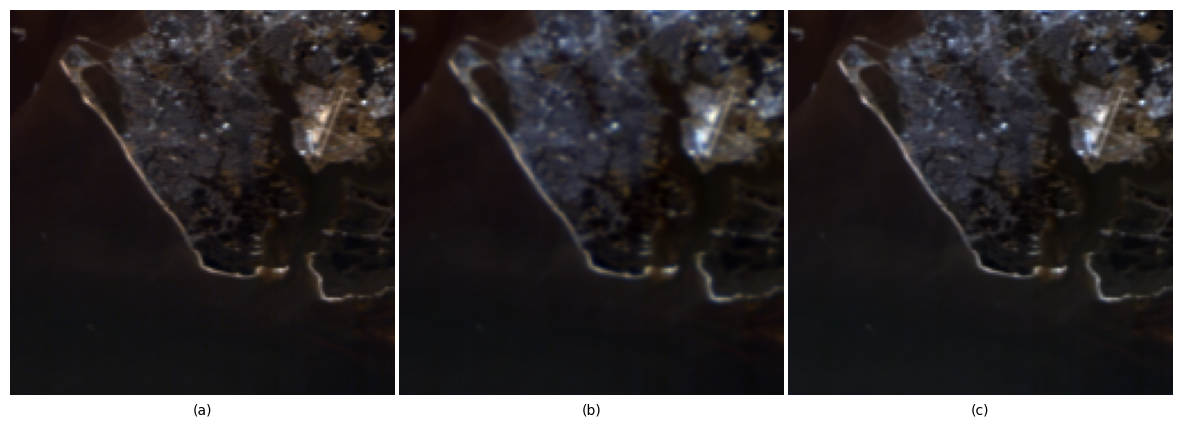

In [48]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)


def visualize_cube(blurred_cube_path,fusion_string):

    blurred_image = sio.loadmat(blurred_cube_path)['blurred']
    image = sio.loadmat(blurred_cube_path)['ref']
    sharpest_image = sio.loadmat(blurred_cube_path)['sharpest_image']
    final_fusion = sio.loadmat(fusion_result_path)[fusion_string]
    #max_value = np.max(blurred_image)
    #print(f"The maximum value in the blurred_image is {max_value}")
    blurred_image = normalize_image(blurred_image)
    image = normalize_image(image)
    sharpest_image = normalize_image(sharpest_image)
    final_fusion = normalize_image(final_fusion)
    #qnr_values = qnr(sharpest_image, blurred_image, final_fusion)
    #print("QNR Value 1: ", qnr_values[0])
    #print("Lambda: ", qnr_values[1])
    #print("D_sr: ", qnr_values[2])
        
    R_f = image[:, :, 42-9]
    G_f = image[:, :, 27-9]
    B_f = image[:, :, 11-9]
    
    R = blurred_image[:, :, 42-9]
    G = blurred_image[:, :, 27-9]
    B = blurred_image[:, :, 11-9]

    Fus_r = final_fusion[:, :, 42-9]
    Fus_g = final_fusion[:, :, 27-9]
    Fus_b = final_fusion[:, :, 11-9]
    
    R_f = (R_f - R_f.min()) / (R_f.max() - R_f.min())
    G_f = (G_f - G_f.min()) / (G_f.max() - G_f.min())
    B_f = (B_f - B_f.min()) / (B_f.max() - B_f.min())
    
    R = (R - R.min()) / (R.max() - R.min())
    G = (G - G.min()) / (G.max() - G.min())
    B = (B - B.min()) / (B.max() - B.min())

    Fus_r = (Fus_r - Fus_r.min()) / (Fus_r.max() - Fus_r.min())
    Fus_g = (Fus_g - Fus_g.min()) / (Fus_g.max() - Fus_g.min())
    Fus_b = (Fus_b - Fus_b.min()) / (Fus_b.max() - Fus_b.min())


    fus_image = np.dstack((Fus_r, Fus_g, Fus_b))
    reference_image = np.dstack((R_f, G_f, B_f))
    blurred_image_stack = np.dstack((R, G, B))

    # Create a figure with 2 subplots
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(reference_image)
    plt.axis('off')
    plt.text(0.5, -0.05, '(a)', transform=plt.gca().transAxes, ha='center')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred_image_stack)
    plt.axis('off')
    plt.text(0.5, -0.05, '(b)', transform=plt.gca().transAxes, ha='center')

    plt.subplot(1, 3, 3)
    plt.imshow(fus_image)
    plt.axis('off')
    plt.text(0.5, -0.05, '(c)', transform=plt.gca().transAxes, ha='center')

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    # New code to plot histograms
    #plt.figure(figsize=(15, 5))
    #plt.savefig('/home/kimado/master/HYPSO-1/fig/016_G.pdf', format='pdf', bbox_inches='tight')
    plt.show()
filename = 'H2010026150016.L1B_ISS.nc_05'
path = os.path.join('/home/kimado/master/DIP-HyperKite/datasets/hico', filename[:-3], filename, filename + '.mat')
fusion_result_path = '/home/kimado/master/DIP-HyperKite/Experiments/DHP_DARN/hico_dataset/N_modules_2/final_prediction.mat'
fus_string = 'H2010026150016.L1B_ISS.nc_05_pred'
visualize_cube(path, fus_string)

In [12]:
import importlib
import sharp as sh
import metric as me
import pandas as pd
import os
import numpy as np

importlib.reload(sh)
importlib.reload(me)

from sharp import SharpeningAlg as shalg
base_path = "/home/kimado/master/HYPSO-1/hico_data/blurred_data"


shalgorithms = {
    "wavelet_haar_lvl3_regular": shalg("wavelet", mother_wavelet="haar", wavelet_level=3, strategy="regular"),
    #"component_substitution": shalg("cs"),
    #"laplacian_fo5": shalg("laplacian", strategy="regular", filter_order=5),
}


shalg_results = {}
for name, alg in shalgorithms.items():
    print (f"Running {name}")
    shalg_results[name] = {}
    ergas_scores = []
    sam_scores = []
    psnr_scores = []
    rmse_scores = []
    cross_correlation_scores = []
    d_r_scores = []
    d_lambda_scores = []
    qnr_scores = []

    npy_files = [f for f in os.listdir(base_path) if f.endswith('.nc_blurred.npz')]
    for npy_file in npy_files:
        print(f"Processing {npy_file}")
        cube_path = os.path.join(base_path, npy_file)

        data = np.load(cube_path)

        init_cube = data['original_cube']
        blurred_cube = data['blurred_cube']

        sbi = 43

        cube = alg.sharpen(blurred_cube, sbi) # SBI er center wavelength
        np.save(os.path.join('/home/kimado/master/HYPSO-1/hico_data/sharp_data', f"{name}_{npy_file}"), cube)

        ergas_scores.append(me.ergas(cube, init_cube, 1))
        sam_scores.append(me.sam(cube, init_cube))
        psnr_scores.append(me.psnr(cube, init_cube))
        rmse_scores.append(me.rmse(cube, init_cube))
        cross_correlation_scores.append(me.cross_correlation(cube, init_cube))
        qnr, lam, dsr = me.qnr(blurred_cube, cube, sbi)
        qnr_scores.append(qnr)
        d_r_scores.append(dsr)
        d_lambda_scores.append(lam)

    ergas_scores = pd.DataFrame(ergas_scores)
    sam_scores = pd.DataFrame(sam_scores)
    psnr_scores = pd.DataFrame(psnr_scores)
    rmse_scores = pd.DataFrame(rmse_scores)
    cross_correlation_scores = pd.DataFrame(cross_correlation_scores)
    qnr_scores = pd.DataFrame(qnr_scores)
    d_r_scores = pd.DataFrame(d_r_scores)
    d_lambda_scores = pd.DataFrame(d_lambda_scores)

    mean_ergas = np.mean(ergas_scores)
    mean_sam = np.mean(sam_scores)
    mean_psnr = np.mean(psnr_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_cross_correlation = np.mean(cross_correlation_scores)
    mean_qnr = np.mean(qnr_scores)
    mean_d_r = np.mean(d_r_scores)
    mean_d_lambda = np.mean(d_lambda_scores)
    
    shalg_results[name]["mean_ergas"] = mean_ergas
    shalg_results[name]["mean_sam"] = mean_sam
    shalg_results[name]["mean_psnr"] = mean_psnr
    shalg_results[name]["mean_rmse"] = mean_rmse
    shalg_results[name]["mean_cross_correlation"] = mean_cross_correlation
    shalg_results[name]["mean_qnr"] = mean_qnr
    shalg_results[name]["mean_d_r"] = mean_d_r
    shalg_results[name]["mean_d_lambda"] = mean_d_lambda
    
    print("Mean ERGAS:", mean_ergas)
    print("Mean SAM:", mean_sam)
    print("Mean PSNR:", mean_psnr)
    print("Mean RMSE:", mean_rmse)
    print("Mean Cross Correlation:", mean_cross_correlation)
    print("Mean D_lambda:", mean_d_lambda)
    print("Mean D_sr:", mean_d_r)
    print("Mean QNR:", mean_qnr)

#save results
#import pickle
#with open('classic_run.pkl', 'wb') as f:
#    pickle.dump(shalg_results, f)
    

Running wavelet_haar_lvl3_regular
Processing edge_image.nc_blurred.npz
Processing H2010154045937.L1B_ISS.nc_blurred.npz
Processing H2010026150016.L1B_ISS.nc_blurred.npz
Mean ERGAS: 12.686898998329092
Mean SAM: 1.616555552435397
Mean PSNR: 34.48008676645542
Mean RMSE: 0.041501597527078285
Mean Cross Correlation: 0.9630012829176701
Mean D_lambda: 0.005243342828930415
Mean D_sr: 0.0
Mean QNR: 0.9947566571710696


In [13]:
import importlib
import sharp as sh
import metric as me
import numpy as np

importlib.reload(sh)
importlib.reload(me)

blur_path = "/home/kimado/master/HYPSO-1/hico_data/blurred_data/H2010026150016.L1B_ISS.nc_blurred.npz"
sharp_path = "/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_haar_lvl3_regular_H2010026150016.L1B_ISS.nc_blurred.npz.npy"

data = np.load(blur_path)
cube = np.load(sharp_path, allow_pickle=True)

init_cube = data['blurred_cube']

#ergas = me.ergas(cube, init_cube, 1)
#sam = me.sam(cube, init_cube)
#psnr = (me.psnr(cube, init_cube))
#rmse = (me.rmse(cube, init_cube))
#cross_correlation = me.cross_correlation(cube, init_cube)
#qnr, lam, dsr = me.qnr(init_cube, cube, sbi)
dsr = me.d_s_r(cube, init_cube[:,:,43])
#qnr_scores.append(qnr)
#d_r_scores.append(dsr)
#d_lambda_scores.append(lam)
#print("Mean ERGAS:", ergas)
#print("Mean SAM:", sam)
#print("Mean PSNR:", psnr)
#print("Mean RMSE:", rmse)
#print("Mean Cross Correlation:", cross_correlation)
#print("Mean D_lambda:", lam)
print("Mean D_sr:", dsr)
#print("Mean QNR:", qnr)


Mean D_sr: 4.3298697960381105e-14


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

blur_path = "/home/kimado/master/HYPSO-1/hico_data/blurred_data/H2010154045937.L1B_ISS.nc_blurred.npz"
sharp_path = "/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_haar_lvl1_regular_H2010154045937.L1B_ISS.nc_blurred.npz.npy"

data = np.load(blur_path)

image = data['blurred_cube']
ref = data['original_cube']

# Assuming 'image' and 'cube' are your 3D numpy arrays
selected_channels_image = image[:, :, 2]
selected_channels_cube = ref[:, :, 2]

# Normalize each channel to the range [0, 1]
normalized_channels_image = (selected_channels_image - selected_channels_image.min()) / (selected_channels_image.max() - selected_channels_image.min())
normalized_channels_cube = (selected_channels_cube - selected_channels_cube.min()) / (selected_channels_cube.max() - selected_channels_cube.min())

# Create a figure
fig = plt.figure(figsize=(10, 30))

# Add first subplot for 'image'
ax1 = fig.add_subplot(121)
ax1.imshow(normalized_channels_image)
ax1.set_title('Blur')
ax1.axis('off')

# Add second subplot for 'cube'
ax2 = fig.add_subplot(122)
ax2.imshow(normalized_channels_cube)
ax2.set_title('GT')
ax2.axis('off')

plt.show()